In [1]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt

import os
import math
from tqdm import tqdm
import itertools
from functools import partial
from omegaconf import OmegaConf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms

from dinov2.data.datasets import LidcIdri
from dinov2.models import vision_transformer as vits

In [2]:
run_path = "../../runs/lidc_vits_reg4"
path_to_checkpoint = os.path.join(run_path, "eval/training_99999/teacher_checkpoint.pth")
path_to_cfg = os.path.join(run_path, "config.yaml")
cfg = OmegaConf.load(path_to_cfg)
state_dict = torch.load(path_to_checkpoint, map_location="cpu")["teacher"]
state_dict = {key: value for key, value in state_dict.items() if 'backbone' in key}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

args = cfg.student
img_size = cfg.augmentations.crops.global_crops_size

vit_kwargs = dict(
    img_size=img_size,
    patch_size=args.patch_size,
    in_chans=args.channels,
    ffn_layer=args.ffn_layer,
    qkv_bias=args.qkv_bias,
    proj_bias=args.proj_bias,
    ffn_bias=args.ffn_bias,
    num_register_tokens=args.num_register_tokens,
    interpolate_offset=args.interpolate_offset,
    interpolate_antialias=args.interpolate_antialias,
    
    init_values=1,
    block_chunks=0,
)
dino = vits.__dict__[args.arch](**vit_kwargs)
dino.load_state_dict(state_dict, strict=True)
dino.cuda()
print("Loaded model")

Loaded model


In [3]:
train_dataset = LidcIdri(split=LidcIdri.Split.TRAIN, root="LIDC_IDRI", extra="extra", enable_targets=True)
val_dataset = LidcIdri(split=LidcIdri.Split.VAL, root="LIDC_IDRI", extra="extra", enable_targets=True)

In [4]:
normalize = transforms.Normalize(mean=0.124, std=0.121)

def collate_fn(inputs):
    batch = dict()
    
    images = []
    labels = []
    
    for i in inputs:
        image, label = i[0], i[1]
        
        image = image.resize((224, 224))
        label = label.resize((224, 224))
        
        image = np.array(image).astype(np.float32)
        label = np.array(label).astype(np.float32)
        
        image = np.expand_dims(image, axis=0)
        label = np.expand_dims(label, axis=0)
        
        images.append(image)
        labels.append(label)
    
    images = torch.stack([normalize(torch.from_numpy(img)) for img in images], dim=0)
    labels = torch.stack([torch.from_numpy(lbl) for lbl in labels], dim=0)
    
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [5]:
def show_mask(image, target):
    np_image = np.array(image)
    np_target = np.array(target)
    
    image_3 = np.repeat(np_image[:, :, np.newaxis], 3, axis=2)
    target_3 = np.repeat(np_target[:, :, np.newaxis], 3, axis=2)
    target_3[:,:,1:] = 0
    
    combined = np.clip(image_3 + target_3, 0, 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1.imshow(image_3)
    ax1.set_title("Image")
    ax2.imshow(combined)
    ax2.set_title("Annotated")
    plt.show()

In [6]:
class LinearClassifier(nn.Module):
    def __init__(self, embed_dim, patch_size, num_labels=1):
        super(LinearClassifier, self).__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.num_labels = num_labels
        
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim,embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim,channels * patch_size**2),
            nn.ReLU(),
            nn.Linear(embed_dim,num_labels)
        )
        self.conv = nn.Conv2d(channels, num_labels, (1,1))

    def forward(self, embeddings):
        B, num_patches, _ = embeddings.shape
        patch_dim = int(np.sqrt(num_patches))
        assert patch_dim * patch_dim == num_patches, "num_patches must be a perfect square"
        
        predictions = self.mlp(embeddings)
        predictions = predictions.view(B, patch_dim, patch_dim, self.num_labels)
        predictions = predictions.permute(0, 3, 1, 2)
        
        return predictions

class DinoSegmentator(nn.Module):
    def __init__(self, dino, classifier):
        super(DinoSegmentator, self).__init__()
        
        self.dino = dino
        self.classifier = classifier
        
        for param in self.dino.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x = self.dino.forward_features(x)["x_norm_patchtokens"]
        
        return self.classifier(x)

In [7]:
classifier = LinearClassifier(
    channels=1,
    embed_dim=384,
    patch_size=14,
    num_labels=1
)
model = DinoSegmentator(dino, classifier).cuda()

In [8]:
class WeightedBCEWithLogitsLossPatch(nn.Module):
    def __init__(self, pos_weight, patch_size):
        super(WeightedBCEWithLogitsLossPatch, self).__init__()
        self.pos_weight = pos_weight
        self.patch_size = patch_size
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, logits, targets):
        B, C, H, W = targets.shape
        
        targets_patches = F.max_pool2d(targets.float(), kernel_size=self.patch_size, stride=self.patch_size)
        
        loss = self.bce(logits, targets_patches)
        return loss

In [12]:
pos_weight = torch.tensor([1 / 0.00002807], dtype=torch.float32).cuda()
criterion = WeightedBCEWithLogitsLossPatch(pos_weight=pos_weight, patch_size=14)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

In [10]:
def compute_iou_patch(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    if union == 0:
        return torch.tensor(1.0) if intersection == 0 else torch.tensor(0.0)
    
    iou = intersection / union
    return iou

def compute_dice_patch(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    total_sum = pred.sum() + target.sum()
    
    if total_sum == 0:
        return torch.tensor(1.0) if intersection == 0 else torch.tensor(0.0)
    
    dice = (2. * intersection) / total_sum
    return dice

def compute_pixel_accuracy_patch(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    correct = (pred == target).sum()
    total = target.numel()
    return correct / total

In [ ]:
eval_freq = 5
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", unit="batch")
    for images, labels in train_loader_tqdm:
        images_cu = images.cuda()
        labels_cu = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(images_cu)
        loss = criterion(outputs, labels_cu)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss / (train_loader_tqdm.n + 1))
    
    if epoch % eval_freq == 0:
        model.eval()
        val_loss = 0.0
        val_iou = 0
        val_dice = 0
        val_pixel_acc = 0
        num_samples = 0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val", unit="batch")
            for images, labels in val_loader_tqdm:
                images_cu = images.cuda()
                labels_cu = labels.cuda()

                outputs = model(images_cu)
                outputs = torch.sigmoid(outputs)

                loss = criterion(outputs, labels_cu)
                val_loss += loss.item()
                val_iou += compute_iou(outputs, labels_cu).item()
                val_dice += compute_dice(outputs, labels_cu).item()
                val_pixel_acc += compute_pixel_accuracy(outputs, labels_cu).item()
                num_samples += 1
                val_loader_tqdm.set_postfix(val_loss=val_loss / (val_loader_tqdm.n + 1),
                                            val_iou=val_iou / num_samples,
                                            val_dice=val_dice / num_samples,
                                            val_pixel_acc=val_pixel_acc / num_samples)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader)}, '
              f'Val Loss: {val_loss / len(val_loader)}, IoU: {val_iou / num_samples}, '
              f'Dice: {val_dice / num_samples}, Pixel Accuracy: {val_pixel_acc / num_samples}')

save_path = os.path.join(run_path, "eval/training_99999/segmentation/classifier.pth")
torch.save(model.classifier.state_dict(), save_path)

Epoch 1/5 - Val: 100%|██████████| 192/192 [02:04<00:00,  1.55batch/s, val_dice=0.000673, val_iou=0.000337, val_loss=2.71, val_pixel_acc=0.915]


Epoch 1/5, Train Loss: 1.4281310548938688, Val Loss: 2.705059852451086, IoU: 0.00033724625572991346, Dice: 0.0006727182366432771, Pixel Accuracy: 0.9150375435128808


Epoch 2/5 - Val: 100%|██████████| 192/192 [24:55<00:00,  7.79s/batch, val_dice=0.000766, val_iou=0.000384, val_loss=2.7, val_pixel_acc=0.927] 


Epoch 2/5, Train Loss: 1.2240827067953641, Val Loss: 2.6982908497254052, IoU: 0.00038421991771760605, Dice: 0.000766172833920109, Pixel Accuracy: 0.9267509781445066


Epoch 3/5 - Val: 100%|██████████| 192/192 [25:01<00:00,  7.82s/batch, val_dice=0.0014, val_iou=0.000706, val_loss=2.73, val_pixel_acc=0.962] 


Epoch 3/5, Train Loss: 1.159076678166624, Val Loss: 2.7289527722944817, IoU: 0.0007055813548457005, Dice: 0.0014026836294149803, Pixel Accuracy: 0.9621105417609215


Epoch 4/5 - Train:  10%|█         | 154/1525 [00:24<03:24,  6.71batch/s, loss=1.11]

In [17]:
contains_positive_idx = None
for i in range(len(val_dataset)):
    img, tar = val_dataset[i]
    if np.sum(np.array(tar).astype(np.float32)) > 0:
        contains_positive_idx = i
        break
contains_positive_idx

167

In [24]:
image, label = val_dataset[167]
        
image = image.resize((224, 224))
label = label.resize((224, 224))

image = np.array(image).astype(np.float32)
label = np.array(label).astype(np.float32)

image = np.expand_dims(image, axis=0)
label = np.expand_dims(label, axis=0)

image = normalize(torch.from_numpy(image)).view((1,1,224,224))
label = torch.from_numpy(label).view((1,1,224,224))

output = model(image.cuda())

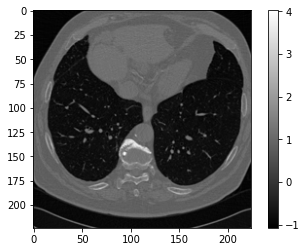

In [26]:
plt.imshow(image[0][0], cmap="gray")
plt.colorbar()
plt.show()

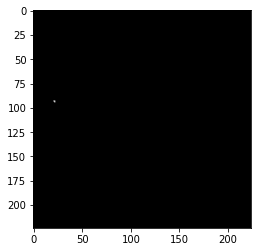

In [23]:
plt.imshow(label[0][0], cmap="gray")
plt.show()

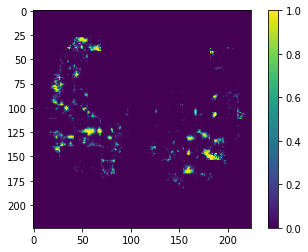

In [25]:
sample_output = output.detach().cpu()[0][0]
sample_output = torch.sigmoid(sample_output).numpy()
plt.imshow(sample_output, vmin=0, vmax=1)
plt.colorbar()
plt.show()